In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import ast
import itertools as it
import warnings
from sklearn import decomposition
from sklearn.preprocessing import MaxAbsScaler

warnings.filterwarnings('ignore')

In [2]:
df_train = pd.read_csv('train.csv', converters={'keydown': ast.literal_eval, 'keyup': ast.literal_eval})
df_test = pd.read_csv('test.csv', converters={'keydown': ast.literal_eval, 'keyup': ast.literal_eval})

In [3]:
_df_train = df_train.copy()
_df_test = df_test.copy()

In [4]:
df_train = _df_train.copy()
df_test = _df_test.copy()

In [182]:
df_train.head()

,id,target,keydown,keyup
0,1,1,"[{'tick': 0, 'code': 107}, {'tick': 36, 'code'...","[{'tick': 21, 'code': 107}, {'tick': 57, 'code..."
1,2,1,"[{'tick': 0, 'code': 112}, {'tick': 1536, 'cod...","[{'tick': 673, 'code': 112}, {'tick': 2208, 'c..."
2,3,1,"[{'tick': 0, 'code': 57}, {'tick': 1587, 'code...","[{'tick': 588, 'code': 57}, {'tick': 2182, 'co..."
3,4,1,"[{'tick': 0, 'code': 50}, {'tick': 941, 'code'...","[{'tick': 710, 'code': 50}, {'tick': 1654, 'co..."
4,5,1,"[{'tick': 0, 'code': 111}, {'tick': 1337, 'cod...","[{'tick': 500, 'code': 111}, {'tick': 1831, 'c..."


In [5]:
def diff(df):
    kd_ticks = df.keydown.apply(lambda keys: [key['tick'] for key in keys])
    ku_ticks = df.keyup.apply(lambda keys: [key['tick'] for key in keys])
    
    kd_ticks_diff = kd_ticks.apply(np.diff)
    ku_ticks_diff = ku_ticks.apply(np.diff)
    
    ku_ticks_diff[ku_ticks_diff.str.len() == 0] =\
        ku_ticks_diff[ku_ticks_diff.str.len() == 0].apply(lambda empty: [-1])
    
    df['keyDownDiffMax'] = kd_ticks_diff.apply(max)
    df['keyDownDiffMin'] = kd_ticks_diff.apply(min)
    df['keyDownDiffSum'] = kd_ticks_diff.apply(np.sum)
    df['keyDownDiffMedian'] = kd_ticks_diff.apply(np.median)
    df['keyDownDiffMean'] = kd_ticks_diff.apply(np.mean)
    df['keyDownDiffDeviation'] = kd_ticks_diff.apply(np.std)
    df['keyDownDiffVariance'] = kd_ticks_diff.apply(np.var)
    
    df['keyUpDiffMax'] = ku_ticks_diff.apply(max)
    df['keyUpDiffMin'] = ku_ticks_diff.apply(min)
    df['keyUpDiffSum'] = ku_ticks_diff.apply(np.sum)
    df['keyUpDiffMedian'] = ku_ticks_diff.apply(np.median)
    df['keyUpDiffMean'] = ku_ticks_diff.apply(np.mean)
    df['keyUpDiffDeviation'] = ku_ticks_diff.apply(np.std)
    df['keyUpDiffVariance'] = ku_ticks_diff.apply(np.var)
    
diff(df_train)
diff(df_test)

In [6]:
def matchKeyPairs(df):
    keyPairsItems = []
    kdTicks = []
    kuTicks = []
    i = 0
    for kds, kus in it.zip_longest(df['keydown'], df['keyup']):
        pairs = []
        kd_ticks = []
        ku_ticks = []
        #Mais keydowns do que keyups
        if len(kds) > len(kus):
            for kd, ku in it.zip_longest(kds, kus, fillvalue=-1):
                kd_ticks.append(kd['tick'])
                if ku != -1:
                    pairs.append([kd['tick'], ku['tick']])
                    ku_ticks.append(ku['tick'])
                else:
                    pairs.append([kd['tick'], -1])
                    ku_ticks.append(-1)
        if len(kds) == len(kus):
            for kd, ku in it.zip_longest(kds, kus):
                #if kd['code'] != ku['code']:
                #else:
                pairs.append([kd['tick'], ku['tick']])
                kd_ticks.append(kd['tick'])
                ku_ticks.append(ku['tick'])
        if len(kds) < len(kus):
            for kd, ku in it.zip_longest(kds, kus, fillvalue=-1):
                ku_ticks.append(ku['tick'])
                if kd != -1:
                    pairs.append([kd['tick'], ku['tick']])
                    kd_ticks.append(kd['tick'])
                else:
                    pairs.append([-1, ku['tick']])
                    kd_ticks.append(-1)

        keyPairsItems.insert(i, pairs)
        kdTicks.insert(i, kd_ticks)
        kuTicks.insert(i, ku_ticks)
        i += 1
    
    result = {}
    result['keyPairsItems'] = keyPairsItems
    result['kdTicks'] = kdTicks
    result['kuTicks'] = kuTicks
    
    return result

resultTrain = matchKeyPairs(df_train)
resultTest = matchKeyPairs(df_test)

train_keypairs = resultTrain['keyPairsItems']
train_kdTicks = resultTrain['kdTicks']
train_kuTicks = resultTrain['kuTicks']

test_keypairs = resultTest['keyPairsItems']
test_kdTicks = resultTest['kdTicks']
test_kuTicks = resultTest['kuTicks']

In [7]:
def firstFeatures(df, kd_ticks, ku_ticks):
    keyDownTotalSum = []
    keyDownTotalMedian = []
    keyDownTotalMean = []
    keyDownTotalDeviation = []
    keyDownTotalVariance = []

    keyUpTotalSum = []
    keyUpTotalMedian = []
    keyUpTotalMean = []
    keyUpTotalDeviation = []
    keyUpTotalVariance = []
    
    for i in range(len(df)):
        keyDownTicks = kd_ticks[i]
        keyUpTicks = ku_ticks[i]
        
        # Calcula os keydowns
        keyDownTotalSum.append(np.sum(keyDownTicks))
        keyDownTotalMedian.append(np.median(keyDownTicks))
        keyDownTotalMean.append(np.mean(keyDownTicks))
        keyDownTotalDeviation.append(np.std(keyDownTicks))
        keyDownTotalVariance.append(np.var(keyDownTicks))
        
        # Calcula os keyups
        keyUpTotalSum.append(np.sum(keyUpTicks))
        keyUpTotalMedian.append(np.median(keyUpTicks))
        keyUpTotalMean.append(np.mean(keyUpTicks))
        keyUpTotalDeviation.append(np.std(keyUpTicks))
        keyUpTotalVariance.append(np.var(keyUpTicks))
    
    df['keyDownTotalSum'] = keyDownTotalSum
    df['keyDownTotalMedian'] = keyDownTotalMedian
    df['keyDownTotalMean'] = keyDownTotalMean
    df['keyDownTotalDeviation'] = keyDownTotalDeviation
    df['keyDownTotalVariance'] = keyDownTotalVariance

    df['keyUpTotalSum'] = keyUpTotalSum
    df['keyUpTotalMedian'] = keyUpTotalMedian
    df['keyUpTotalMean'] = keyUpTotalMean
    df['keyUpTotalDeviation'] = keyUpTotalDeviation
    df['keyUpTotalVariance'] = keyUpTotalVariance

firstFeatures(df_train, train_kdTicks, train_kuTicks)
firstFeatures(df_test, test_kdTicks, test_kuTicks)

In [8]:
def prepareFeatures(df, keyPairsItems):
    intervalMax = []
    intervalMin = []
    intervalSum = []
    intervalMedian = []
    intervalMean = []
    intervalDeviation = []
    intervalVariance = []
    
    pressedMax = []
    pressedMin = []
    pressedSum = []
    pressedMedian = []
    pressedMean = []
    pressedDeviation = []
    pressedVariance = []
    
    for keyPairs in keyPairsItems:
        intervals = []
        pressed = []
        for i in range(len(keyPairs)):
            # Calcula os intervalos
            if i+1 < len(keyPairs):
                if keyPairs[i][1] == -1 or keyPairs[i+1][0] == -1:
                    intervals.append(-99999)
                else:
                    intervals.append(keyPairs[i+1][0] - keyPairs[i][1])
            # Calcula os pressionamentos
            if keyPairs[i][1] == -1 or keyPairs[i][0] == -1:
                pressed.append(-99999)
            else:
                pressed.append(keyPairs[i][1] - keyPairs[i][0])
        
        intervalMax.append(max(intervals))
        intervalMin.append(min(intervals))
        intervalSum.append(np.sum(intervals))
        intervalMedian.append(np.median(intervals))
        intervalMean.append(np.mean(intervals))
        intervalDeviation.append(np.std(intervals))
        intervalVariance.append(np.var(intervals))
        
        pressedMax.append(max(pressed))
        pressedMin.append(min(pressed))
        pressedSum.append(np.sum(pressed))
        pressedMedian.append(np.median(pressed))
        pressedMean.append(np.mean(pressed))
        pressedDeviation.append(np.std(pressed))
        pressedVariance.append(np.var(pressed))

    df['intervalMax'] = intervalMax
    df['intervalMin'] = intervalMin
    df['intervalSum'] = intervalSum
    df['intervalMedian'] = intervalMedian
    df['intervalMean'] = intervalMean
    df['intervalDeviation'] = intervalDeviation
    df['intervalVariance'] = intervalVariance
    
    df['pressedMax'] = pressedMax
    df['pressedMin'] = pressedMin
    df['pressedSum'] = pressedSum
    df['pressedMedian'] = pressedMedian
    df['pressedMean'] = pressedMean
    df['pressedDeviation'] = pressedDeviation
    df['pressedVariance'] = pressedVariance
    
    df.fillna(0, inplace=True)
    df.drop(['id', 'keydown', 'keyup'], axis=1, inplace=True, errors='ignore')
    
    for column in df.columns:
        if df[column].dtype == np.float64:
            df[column] = df[column].round(1)


prepareFeatures(df_train, train_keypairs)
prepareFeatures(df_test, test_keypairs)

#df_train_ = df_train.copy()
#df_train_.drop(['target'], axis=1, inplace=True, errors='ignore')

#df_full = pd.concat([df_train_,df_test])
#df_full.fillna(0, inplace=True)

#maxAbsScaler = MaxAbsScaler()
#full_scaled = maxAbsScaler.fit_transform(df_full)
#train_scaled = maxAbsScaler.transform(df_train_)
#test_scaled = maxAbsScaler.transform(df_test)

#pca_ = decomposition.PCA(n_components=2)
#full_pca = pca_.fit(full_scaled)
#train_pca = pca_.transform(train_scaled)
#test_pca = pca_.transform(test_scaled)

#df_train['pca_x'] = train_pca[:,0]
#df_train['pca_y'] = train_pca[:,1]

#df_test['pca_x'] = test_pca[:,0]
#df_test['pca_y'] = test_pca[:,1]

In [187]:
df_train.head()

,target,keyDownDiffMax,keyDownDiffMin,keyDownDiffSum,keyDownDiffMedian,keyDownDiffMean,keyDownDiffDeviation,keyDownDiffVariance,keyUpDiffMax,keyUpDiffMin,...,intervalMean,intervalDeviation,intervalVariance,pressedMax,pressedMin,pressedSum,pressedMedian,pressedMean,pressedDeviation,pressedVariance
0,1,51,29,726,41.0,40.3,5.4,28.9,51,28,...,19.8,3.7,14.1,27,12,395,21.0,20.8,4.6,20.9
1,1,1536,1513,28892,1521.0,1520.6,6.0,36.4,1538,1512,...,853.3,5.1,25.9,675,660,13342,666.0,667.1,4.3,18.8
2,1,1613,1587,30416,1599.0,1600.8,7.2,51.7,1615,1590,...,1005.7,3.9,15.4,603,588,11911,596.0,595.6,5.5,30.6
3,1,950,931,17930,944.0,943.7,4.0,15.9,956,932,...,228.9,4.1,17.1,723,708,14294,713.0,714.7,4.8,22.8
4,1,1351,1323,25402,1337.0,1336.9,6.8,46.0,1348,1323,...,843.0,4.1,16.6,500,486,9874,494.0,493.7,5.2,27.5


In [9]:
features = df_train.columns.difference(['target'])

X = df_train[features].values
y = df_train['target'].values

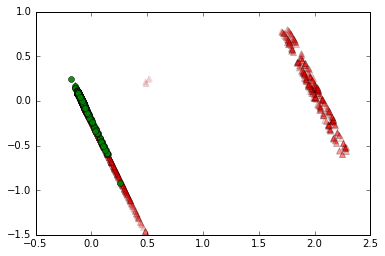

In [10]:
X_scaled = MaxAbsScaler().fit_transform(X)

pca = decomposition.PCA(n_components=2)
data = pca.fit_transform(X_scaled)

data0 = data[df_train[df_train['target'] == 0].index.values]
data1 = data[df_train[df_train['target'] == 1].index.values]

plt.plot(data1[:,0], data1[:,1], '^', color='r', alpha=0.1)
plt.plot(data0[:,0], data0[:,1], 'o', color='g', alpha=0.9)

In [11]:
pca.explained_variance_ratio_.sum()

0.95316095091549147

In [197]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=1000)
classifier = RandomForestClassifier(random_state=1000, bootstrap=False, criterion='entropy', n_estimators=349, max_depth=13)
#classifier = AdaBoostClassifier(classifier)

scores = cross_val_score(classifier, X, y, scoring='log_loss', cv=cv, n_jobs=-1)

scores, np.mean(scores)

(array([-0.00568371, -0.00325932, -0.00417627, -0.00412606, -0.00401464,
        -0.00478227, -0.00332531, -0.00653292, -0.00735375, -0.00547072]),
 -0.0048724980404414083)

In [15]:
import xgboost as xgb
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedKFold

cv = StratifiedKFold(y, n_folds=10, shuffle=True, random_state=1000)
classifier2 = xgb.XGBClassifier(seed=980, n_estimators=383, max_depth=3, min_child_weight=1, subsample=0.95, colsample_bytree=0.45, gamma=0.1)
scores2 = cross_val_score(classifier2, X, y, scoring='log_loss', cv=cv, n_jobs=-1)
scores2, np.mean(scores2)

(array([-0.0049319 , -0.0016525 , -0.0012557 , -0.00287973, -0.00608419,
        -0.00341171, -0.00298283, -0.00652859, -0.00616833, -0.00261709]),
 -0.0038512561247881993)

In [14]:
from sklearn.grid_search import GridSearchCV

param_grid = {
            'max_depth':[3],
            'min_child_weight':[1],
            'subsample':[0.95],
            'colsample_bytree':[0.45],
            'gamma':[0.1],
#            'n_estimators':[i for i in range(300,400,2)]
            'n_estimators':[383],
            'seed':[i for i in range(1001,1500,1)]
}

gs_classifier = GridSearchCV(classifier2, param_grid, cv=cv, scoring="log_loss", verbose=1)
gs_classifier.fit(X, y)

classifier = gs_classifier.best_estimator_ 

gs_classifier.best_params_, gs_classifier.best_score_

Fitting 10 folds for each of 499 candidates, totalling 4990 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  7.2min
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed: 25.8min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed: 56.3min
[Parallel(n_jobs=1)]: Done 799 tasks       | elapsed: 99.1min
[Parallel(n_jobs=1)]: Done 1249 tasks       | elapsed: 154.0min
[Parallel(n_jobs=1)]: Done 1799 tasks       | elapsed: 221.2min
[Parallel(n_jobs=1)]: Done 2449 tasks       | elapsed: 300.4min
[Parallel(n_jobs=1)]: Done 3199 tasks       | elapsed: 391.9min
[Parallel(n_jobs=1)]: Done 4049 tasks       | elapsed: 495.4min
[Parallel(n_jobs=1)]: Done 4990 out of 4990 | elapsed: 609.7min finished


({'colsample_bytree': 0.45,
  'gamma': 0.1,
  'max_depth': 3,
  'min_child_weight': 1,
  'n_estimators': 383,
  'seed': 1021,
  'subsample': 0.95},
 -0.0040021603580654456)

In [16]:
classifier2.fit(X, y)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.45,
       gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=383, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=980, silent=True, subsample=0.95)

In [17]:
y_pred = classifier.predict_proba(df_test[features])[:,1]
submission = pd.read_csv('submission_sample.csv')
submission['target'] = y_pred
submission.to_csv('result.csv', index=False)

In [19]:
y_pred = classifier2.predict(X)
df_error = df_train[y_pred != y]
len(df_error), df_error.index.values[0:5]

(0, array([], dtype=int64))

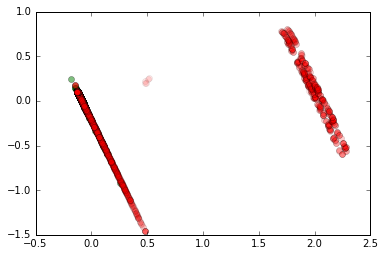

In [20]:
plt.plot(data0[:,0], data0[:,1], 'o', color='g', alpha=0.5)
plt.plot(data1[:,0], data1[:,1], 'o', color='r', alpha=0.1)

data3 = data[df_error.index.values]
plt.plot(data3[:,0], data3[:,1], 'o', color='y', alpha=0.9)

In [202]:
importances = classifier.feature_importances_
indices = np.argsort(importances)[::-1]
print("Feature ranking:")
for f in range(len(importances)):
    print("   %5s: %f%%" % (features[indices[f]], importances[indices[f]]*100))

Feature ranking:
   pressedDeviation: 18.790535%
   pressedVariance: 15.715027%
   intervalVariance: 7.198869%
   intervalMin: 6.115571%
   intervalDeviation: 5.933404%
   keyUpDiffDeviation: 4.006701%
   keyDownDiffDeviation: 3.713563%
   keyUpDiffVariance: 3.668655%
   keyUpDiffMedian: 3.307350%
   keyDownDiffVariance: 3.147914%
   keyDownDiffMedian: 2.384565%
   pressedMean: 2.381884%
   pressedMax: 2.264307%
   intervalMedian: 2.187590%
   pressedMedian: 2.176083%
   keyDownTotalMedian: 1.990630%
   keyDownTotalMean: 1.729562%
   pressedSum: 1.613738%
   keyUpTotalMedian: 1.424723%
   keyUpDiffMin: 1.321894%
   keyUpTotalMean: 1.213143%
   keyDownTotalSum: 1.190843%
   keyDownDiffMin: 1.009922%
   pressedMin: 0.966309%
   keyUpTotalSum: 0.913857%
   keyUpDiffMean: 0.736325%
   keyDownDiffMean: 0.589516%
   intervalMean: 0.451803%
   intervalMax: 0.323258%
   keyUpDiffMax: 0.301648%
   intervalSum: 0.264225%
   keyDownDiffMax: 0.224699%
   keyUpDiffSum: 0.151193%
   keyDownDiffSum: 